In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import gillespy2
import dask
import copy
import json
import time
import numpy as np
import pandas as  pd
import matplotlib.pyplot as plt
from tsfresh.feature_extraction.settings import MinimalFCParameters
from dask.distributed import Client
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sciope.utilities.priors import uniform_prior
from sciope.utilities.summarystats import auto_tsfresh
from sciope.utilities.distancefunctions import naive_squared
from sciope.inference.abc_inference import ABC

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Autoencoder

In [2]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, latent_dim=16):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features, self.latent_dim = seq_len, n_features, 16

        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU())

        self.layer3 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU())

        self.maxpool = nn.MaxPool1d(3)
        self.fc1 = nn.Linear(64, 16)

    def forward(self, x):
        y = self.layer1(x)
        y = self.layer2(y)
        y = self.layer3(y)
        y = self.layer4(y)
        y = self.maxpool(y)
        y = y.view(-1, 16*4)
        y = self.fc1(y)
        return y

In [3]:
class Decoder(nn.Module):
    def __init__(self, seq_len, latent_dim=16, n_features=1):
        super(Decoder, self).__init__()
        self.seq_len, self.latent_dim = seq_len, latent_dim

        self.fc2 = nn.Linear(16, 16*4)
        self.fc3 = nn.Linear(4, 13)

        self.layer1 = nn.Sequential(
            nn.ConvTranspose1d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.ConvTranspose1d(in_channels=32, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU())

        self.layer3 = nn.Sequential(
            nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.ConvTranspose1d(in_channels=16, out_channels=3, kernel_size=3, stride=2, padding=1),
            nn.ReLU())

    def forward(self, x):
        y = self.fc2(x)
        y = y.view(16, 4)
        y = self.fc3(y)
        #print(y.shape)
        y = self.layer1(y)
        y = self.layer2(y)
        y = self.layer3(y)
        y = self.layer4(y)
        return y 

In [26]:
class Autoencoder(nn.Module):
    def __init__(self, seq_len, n_features, latent_dim=16):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, latent_dim).to(device)
        self.decoder = Decoder(seq_len, latent_dim, n_features).to(device)

    def forward(self, x):
        #print(x.shape)
        data = x.tolist()
        ss = []
        for i in data:
            x = torch.tensor([i[0], i[1], i[2]])
            y = self.encoder(x).flatten().tolist()
            ss.append(y)

        #return np.mean(ss, axis=0) 
        #print(np.array(ss).shape)
        return np.array(ss)      

In [27]:
model = torch.load('tcn_100_100.pth').to(device)

## Data generation model

In [6]:
# Use the model definition below
class Vilar_Oscillator(gillespy2.Model):
    def __init__(self, parameter_values=None):
        gillespy2.Model.__init__(self, name="Vilar_Oscillator")
        self.volume = 1

        # Parameters
        self.add_parameter(gillespy2.Parameter(name="alpha_a", expression=50))
        self.add_parameter(gillespy2.Parameter(name="alpha_a_prime", expression=500))
        self.add_parameter(gillespy2.Parameter(name="alpha_r", expression=0.01))
        self.add_parameter(gillespy2.Parameter(name="alpha_r_prime", expression=50))
        self.add_parameter(gillespy2.Parameter(name="beta_a", expression=50))
        self.add_parameter(gillespy2.Parameter(name="beta_r", expression=5))
        self.add_parameter(gillespy2.Parameter(name="delta_ma", expression=10))
        self.add_parameter(gillespy2.Parameter(name="delta_mr", expression=0.5))
        self.add_parameter(gillespy2.Parameter(name="delta_a", expression=1))
        self.add_parameter(gillespy2.Parameter(name="delta_r", expression=0.2))
        self.add_parameter(gillespy2.Parameter(name="gamma_a", expression=1))
        self.add_parameter(gillespy2.Parameter(name="gamma_r", expression=1))
        self.add_parameter(gillespy2.Parameter(name="gamma_c", expression=2))
        self.add_parameter(gillespy2.Parameter(name="theta_a", expression=50))
        self.add_parameter(gillespy2.Parameter(name="theta_r", expression=100))

        # Species
        self.add_species(gillespy2.Species(name="Da", initial_value=1, mode="discrete"))
        self.add_species(gillespy2.Species(name="Da_prime", initial_value=0, mode="discrete"))
        self.add_species(gillespy2.Species(name="Ma", initial_value=0, mode="discrete"))
        self.add_species(gillespy2.Species(name="Dr", initial_value=1, mode="discrete"))
        self.add_species(gillespy2.Species(name="Dr_prime", initial_value=0, mode="discrete"))
        self.add_species(gillespy2.Species(name="Mr", initial_value=0, mode="discrete"))
        self.add_species(gillespy2.Species(name="C", initial_value=10, mode="discrete"))
        self.add_species(gillespy2.Species(name="A", initial_value=10, mode="discrete"))
        self.add_species(gillespy2.Species(name="R", initial_value=10, mode="discrete"))

        # Reactions
        self.add_reaction(gillespy2.Reaction(name="r1", reactants={'Da_prime': 1}, products={'Da': 1}, rate=self.listOfParameters["theta_a"]))
        self.add_reaction(gillespy2.Reaction(name="r2", reactants={'Da': 1, 'A': 1}, products={'Da_prime': 1}, rate=self.listOfParameters["gamma_a"]))
        self.add_reaction(gillespy2.Reaction(name="r3", reactants={'Dr_prime': 1}, products={'Dr': 1}, rate=self.listOfParameters["theta_r"]))
        self.add_reaction(gillespy2.Reaction(name="r4", reactants={'Dr': 1, 'A': 1}, products={'Dr_prime': 1}, rate=self.listOfParameters["gamma_r"]))
        self.add_reaction(gillespy2.Reaction(name="r5", reactants={'Da_prime': 1}, products={'Da_prime': 1, 'Ma': 1}, rate=self.listOfParameters["alpha_a_prime"]))
        self.add_reaction(gillespy2.Reaction(name="r6", reactants={'Da': 1}, products={'Da': 1, 'Ma': 1}, rate=self.listOfParameters["alpha_a"]))
        self.add_reaction(gillespy2.Reaction(name="r7", reactants={'Ma': 1}, products={}, rate=self.listOfParameters["delta_ma"]))
        self.add_reaction(gillespy2.Reaction(name="r8", reactants={'Ma': 1}, products={'A': 1, 'Ma': 1}, rate=self.listOfParameters["beta_a"]))
        self.add_reaction(gillespy2.Reaction(name="r9", reactants={'Da_prime': 1}, products={'Da_prime': 1, 'A': 1}, rate=self.listOfParameters["theta_a"]))
        self.add_reaction(gillespy2.Reaction(name="r10", reactants={'Dr_prime': 1}, products={'Dr_prime': 1, 'A': 1}, rate=self.listOfParameters["theta_a"]))
        self.add_reaction(gillespy2.Reaction(name="r11", reactants={'A': 1}, products={}, rate=self.listOfParameters["gamma_c"]))
        self.add_reaction(gillespy2.Reaction(name="r12", reactants={'A': 1, 'R': 1}, products={'C': 1}, rate=self.listOfParameters["gamma_c"]))
        self.add_reaction(gillespy2.Reaction(name="r13", reactants={'Dr_prime': 1}, products={'Dr_prime': 1, 'Mr': 1}, rate=self.listOfParameters["alpha_r_prime"]))
        self.add_reaction(gillespy2.Reaction(name="r14", reactants={'Dr': 1}, products={'Dr': 1, 'Mr': 1}, rate=self.listOfParameters["alpha_r"]))
        self.add_reaction(gillespy2.Reaction(name="r15", reactants={'Mr': 1}, products={}, rate=self.listOfParameters["delta_mr"]))
        self.add_reaction(gillespy2.Reaction(name="r16", reactants={'Mr': 1}, products={'Mr': 1, 'R': 1}, rate=self.listOfParameters["beta_r"]))
        self.add_reaction(gillespy2.Reaction(name="r17", reactants={'R': 1}, products={}, rate=self.listOfParameters["delta_r"]))
        self.add_reaction(gillespy2.Reaction(name="r18", reactants={'C': 1}, products={'R': 1}, rate=self.listOfParameters["delta_a"]))

        # Timespan
        self.timespan(np.linspace(0, 200, 201))

In [7]:
vilar_model = Vilar_Oscillator()

## Prior distribution

In [8]:
default_param = np.array(list(vilar_model.listOfParameters.items()))[:, 1]

bound = []
for exp in default_param:
    bound.append(float(exp.expression))

# Set the bounds
bound = np.array(bound)
dmin = bound * 0.1
dmax = bound * 2.0

# Here we use uniform prior
uni_prior = uniform_prior.UniformPrior(dmin, dmax)

## Generate simulated data

In [9]:
parameter_names = ['alpha_a', 'alpha_a_prime', 'alpha_r', 'alpha_r_prime', 'beta_a', 'beta_r', 'delta_ma',
                    'delta_mr', 'delta_a', 'delta_r', 'gamma_a', 'gamma_r', 'gamma_c', 'theta_a', 'theta_r']

solver = gillespy2.solvers.SSACSolver(model=vilar_model)

def normalize_data(d, new, min_max):
    for j in d:
        i = np.array(j)
        new.append((np.array(i) - np.min(i)) / (np.max(i) - np.min(i)))
        min_max.append([np.min(i), np.max(i)])

def simulator(params):
    res = vilar_model.run(
            number_of_trajectories = 10,
            solver = solver,
            variables = {parameter_names[i] : np.asarray(params[i]) for i in range(len(parameter_names))})

    # separate C, A, R in simulated data
    dic = {}
    dic['c'], dic['a'], dic['r'] = [], [], []
    for i in res:
        dic['c'].append(i['C'])
        dic['a'].append(i['A'])
        dic['r'].append(i['R'])

    # normalize data
    data = dic
    n_c, n_a, n_r, m_c, m_a, m_r = [], [], [], [], [], []
    normalize_data(data['c'], n_c, m_c)
    normalize_data(data['a'], n_a, m_a)
    normalize_data(data['r'], n_r, m_r)

    # calculate variance for observed data
    #var_c = np.mean(np.var(n_c, axis=0))
    #var_a = np.mean(np.var(n_a, axis=0))
    #var_r = np.mean(np.var(n_r, axis=0))

    # preprocess the data to make it match the size of encoder input
    All_data = []
    for i in range(len(n_c)):
        data = []
        data.append([n_c[i], m_c[i]])
        data.append([n_a[i], m_a[i]])
        data.append([n_r[i], m_r[i]])
        All_data.append(data)

    dataset = []
    for i in All_data:
        c = np.asarray(i[0][0])
        a = np.asarray(i[1][0])
        r = np.asarray(i[2][0])
        #v = torch.tensor([np.mean(np.array([i[0][1][0], i[1][1][0], i[2][1][0]]))]).float()
        dataset.append(np.asarray([c, a, r]))

    return np.asarray(dataset)

## Calculate summary statistics

In [97]:
from sciope.utilities.summarystats.summary_base import SummaryBase

class Encoder_Statistics(SummaryBase):

    def __init__(self, mean_trajectories=False, use_logger=False):
        self.name = 'ANN_Statistics'
        super(Encoder_Statistics, self).__init__(self.name, mean_trajectories, use_logger)
        if self.use_logger:
            self.logger = ml.SciopeLogger().get_logger()
            self.logger.info("Encoder_Statistics summary statistic initialized")

    def compute(self, data):
        data_arr = np.array(data)
        assert len(data_arr.shape) == 3, "required input shape is (n_points, n_species, n_timepoints)"

        #res = model_cnn.predict(data_arr)
        #res = denormalize_data(res, dmin, dmax)
        data = torch.tensor(data_arr).to(device)
        #print(data.shape)
        res = model(data)
        #print(res.shape)

        #if self.mean_trajectories:
            #res = np.asarray(np.mean(res, axis=0))  # returns a scalar, so we cast it as an array

        if self.use_logger:
            self.logger.info("Encoder_Statistics summary statistic: processed data matrix of shape {0} and generated summaries"
                            " of shape {1}".format(data.shape, res.shape))
        #print(res.shape)
        return res

In [98]:
enc_stat = Encoder_Statistics()

## Calculate naive squared distance

In [11]:
from sciope.utilities.distancefunctions.distance_base import DistanceBase
from sciope.utilities.housekeeping import sciope_logger as ml

class NaiveSquaredDistance(DistanceBase):
    def __init__(self, use_logger=False):
        self.name = 'NaiveSquared'
        super(NaiveSquaredDistance, self).__init__(self.name, use_logger)
        if self.use_logger:
            self.logger = ml.SciopeLogger().get_logger()
            self.logger.info("NaiveSquaredDistance distance function initialized")

    
    def compute(self, data, sim):
        # Make sure we have numpy arrays
        #data = np.asarray(data)
        #sim = np.asarray(sim)
        data = np.asarray(data)[0]
        sim = np.asarray(np.mean(np.array(sim), axis=0))
        # Check that we have equal shapes
        np.testing.assert_equal(sim.shape, data.shape, "Please validate the values and ensure shape equality of the "
                                                    "arguments.")

        res = (data - sim) ** 2

        if self.use_logger:
            self.logger.info("NaiveSquaredDistance: processed data matrices of shape {0} and calculated distance"
                            " of {1}".format(data.shape, res))
        return res

In [93]:
class EuclideanDistance(DistanceBase):
    def __init__(self, use_logger=False):
        self.name = 'Euclidean'
        super(EuclideanDistance, self).__init__(self.name, use_logger)
        if self.use_logger:
            self.logger = ml.SciopeLogger().get_logger()
            self.logger.info("EuclideanDistance distance function initialized")

    
    def compute(self, data, sim):    
        # Make sure we have numpy arrays
        #data = np.asarray(data)
        #sim = np.asarray(sim)
        data = np.asarray(data)[0]
        sim = np.asarray(np.mean(np.array(sim), axis=0))
        #print(data.shape, sim.shape)
        # Check that we have equal shapes
        np.testing.assert_equal(sim.shape, data.shape, "Please validate the values and ensure shape equality of the "
                                                    "arguments.")

        res = np.linalg.norm(data - sim)

        if self.use_logger:
            self.logger.info("EuclideanDistance: processed data matrices of shape {0} and calculated distance"
                            " of {1}".format(data.shape, res))
        return res

In [94]:
#distance = NaiveSquaredDistance()
distance = EuclideanDistance()

## Generate observed data

In [95]:
#params = np.asarray([50.0, 500.0, 0.01, 50.0, 50.0, 5.0, 10.0, 0.5, 1.0, 0.2, 1.0, 1.0, 2.0, 50.0, 100.0])
default_param = np.array(list(vilar_model.listOfParameters.items()))[:, 1]
obs_data = simulator(params=default_param)
print(obs_data.shape)
obs_stats = enc_stat.compute(obs_data)
#print(obs_stats.shape)
#print(obs_stats, '\n')
print(np.asarray(np.mean(obs_stats, axis=0)).shape)

(10, 3, 201)
(16,)


## ABC

In [ ]:
import sciope.inference.smc_abc as smc
from sciope.inference import abc_inference
from sciope.utilities.epsilonselectors.relative_epsilon_selector import RelativeEpsilonSelector

smcabc = smc.SMCABC(obs_data, simulator, uni_prior, use_logger=False,
                    distance_function=distance,
                    summaries_function=enc_stat.compute)

# Run the SMC-ABC algorithm
max_rounds = 6
eps_selector = RelativeEpsilonSelector(20, max_rounds)
posterior = smcabc.infer(num_samples=10, batch_size=10, chunk_size=10, eps_selector=eps_selector)

In [114]:
'''
def s_model(params):
    d = simulator(params)
    s = enc_stat.compute(d)
    return {'data': s}
'''

In [ ]:
'''
import os
import tempfile
import pyabc

pyabc.settings.set_figure_params('pyabc')

prior = pyabc.Distribution(mu=pyabc.RV("uniform", dmin, dmax))

abc = pyabc.ABCSMC(s_model, prior, distance, population_size=1000)
db_path = os.path.join(tempfile.gettempdir(), "test.db")
abc.new("sqlite:///" + db_path, {"data": obs_stats})
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)
'''

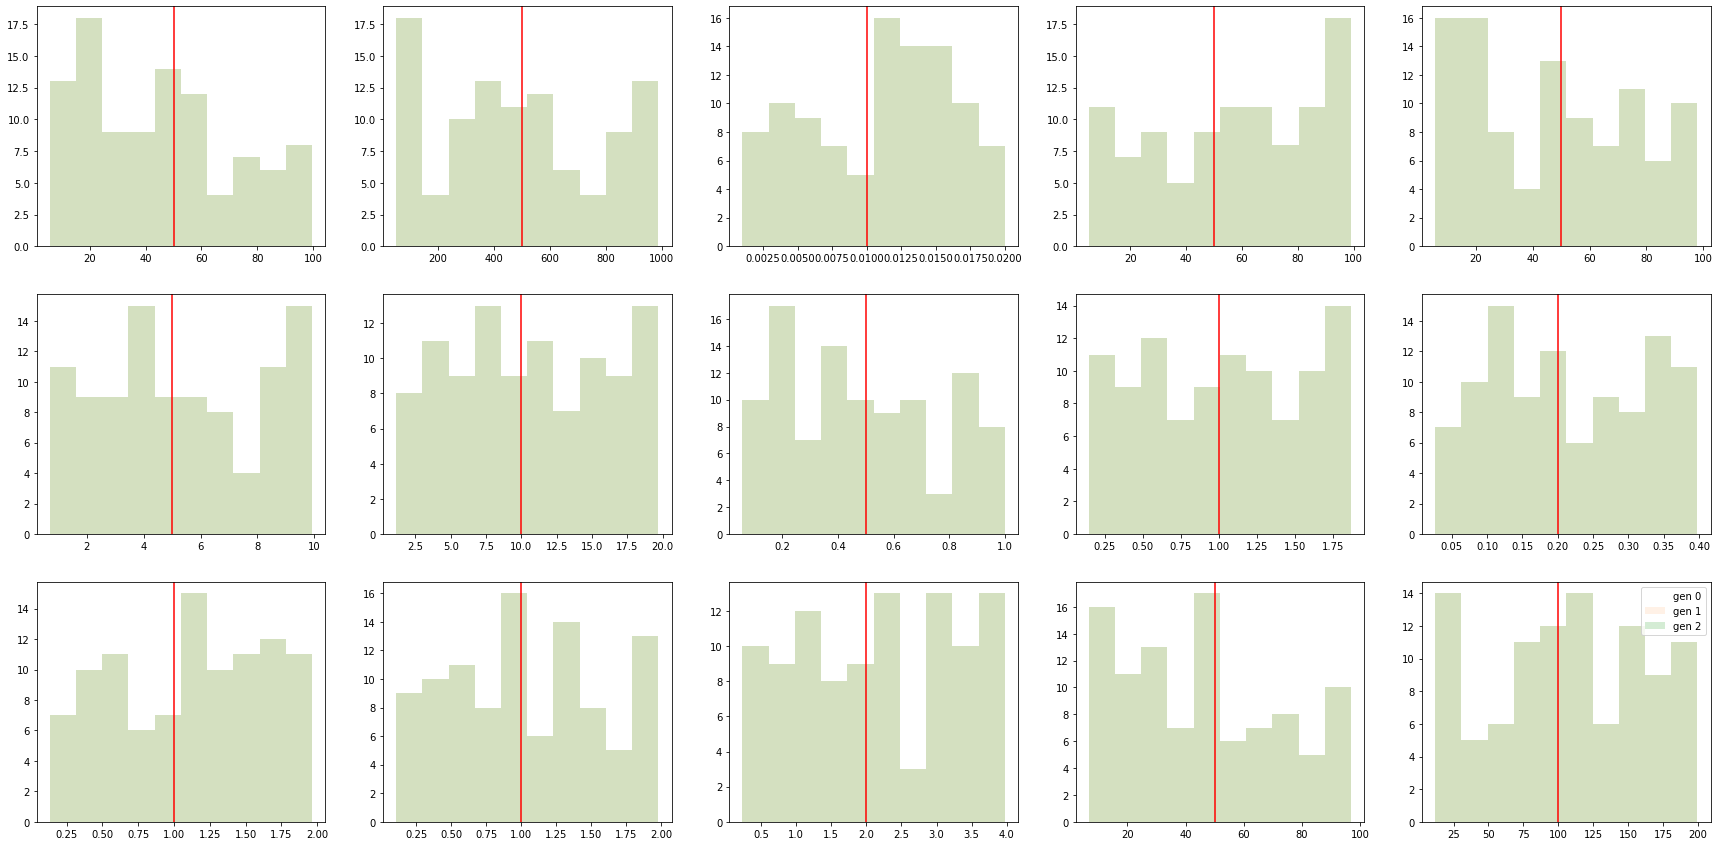

In [ ]:
true_params = np.asarray([50.0, 500.0, 0.01, 50.0, 50.0, 5.0, 10.0, 0.5, 1.0, 0.2, 1.0, 1.0, 2.0, 50.0, 100.0])
lower_bounds = true_params * 0.1
upper_bounds = true_params * 2.0
parameter_names = list(vilar_model.listOfParameters.keys())

#plt.figure(figsize=[50,6])
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for j in range(len(posterior)):
    posterior1 = np.vstack(posterior[j]['accepted_samples'])
    #print(posterior1.shape)

    for i in range(posterior1.shape[1]):
        if i < 5:
            a, b = 0, i
        elif 4 < i and i < 10:
            a, b = 1, i-5
        else:
            a, b = 2, i-10
        #plt.subplot(5,3,i+1)
        axs[a, b].hist(posterior1[:,i], alpha=0.1*j, label=f'gen {j}')
        if j == len(posterior)-1:
            axs[a, b].axvline(true_params[i], color='red')
plt.legend()
plt.show()


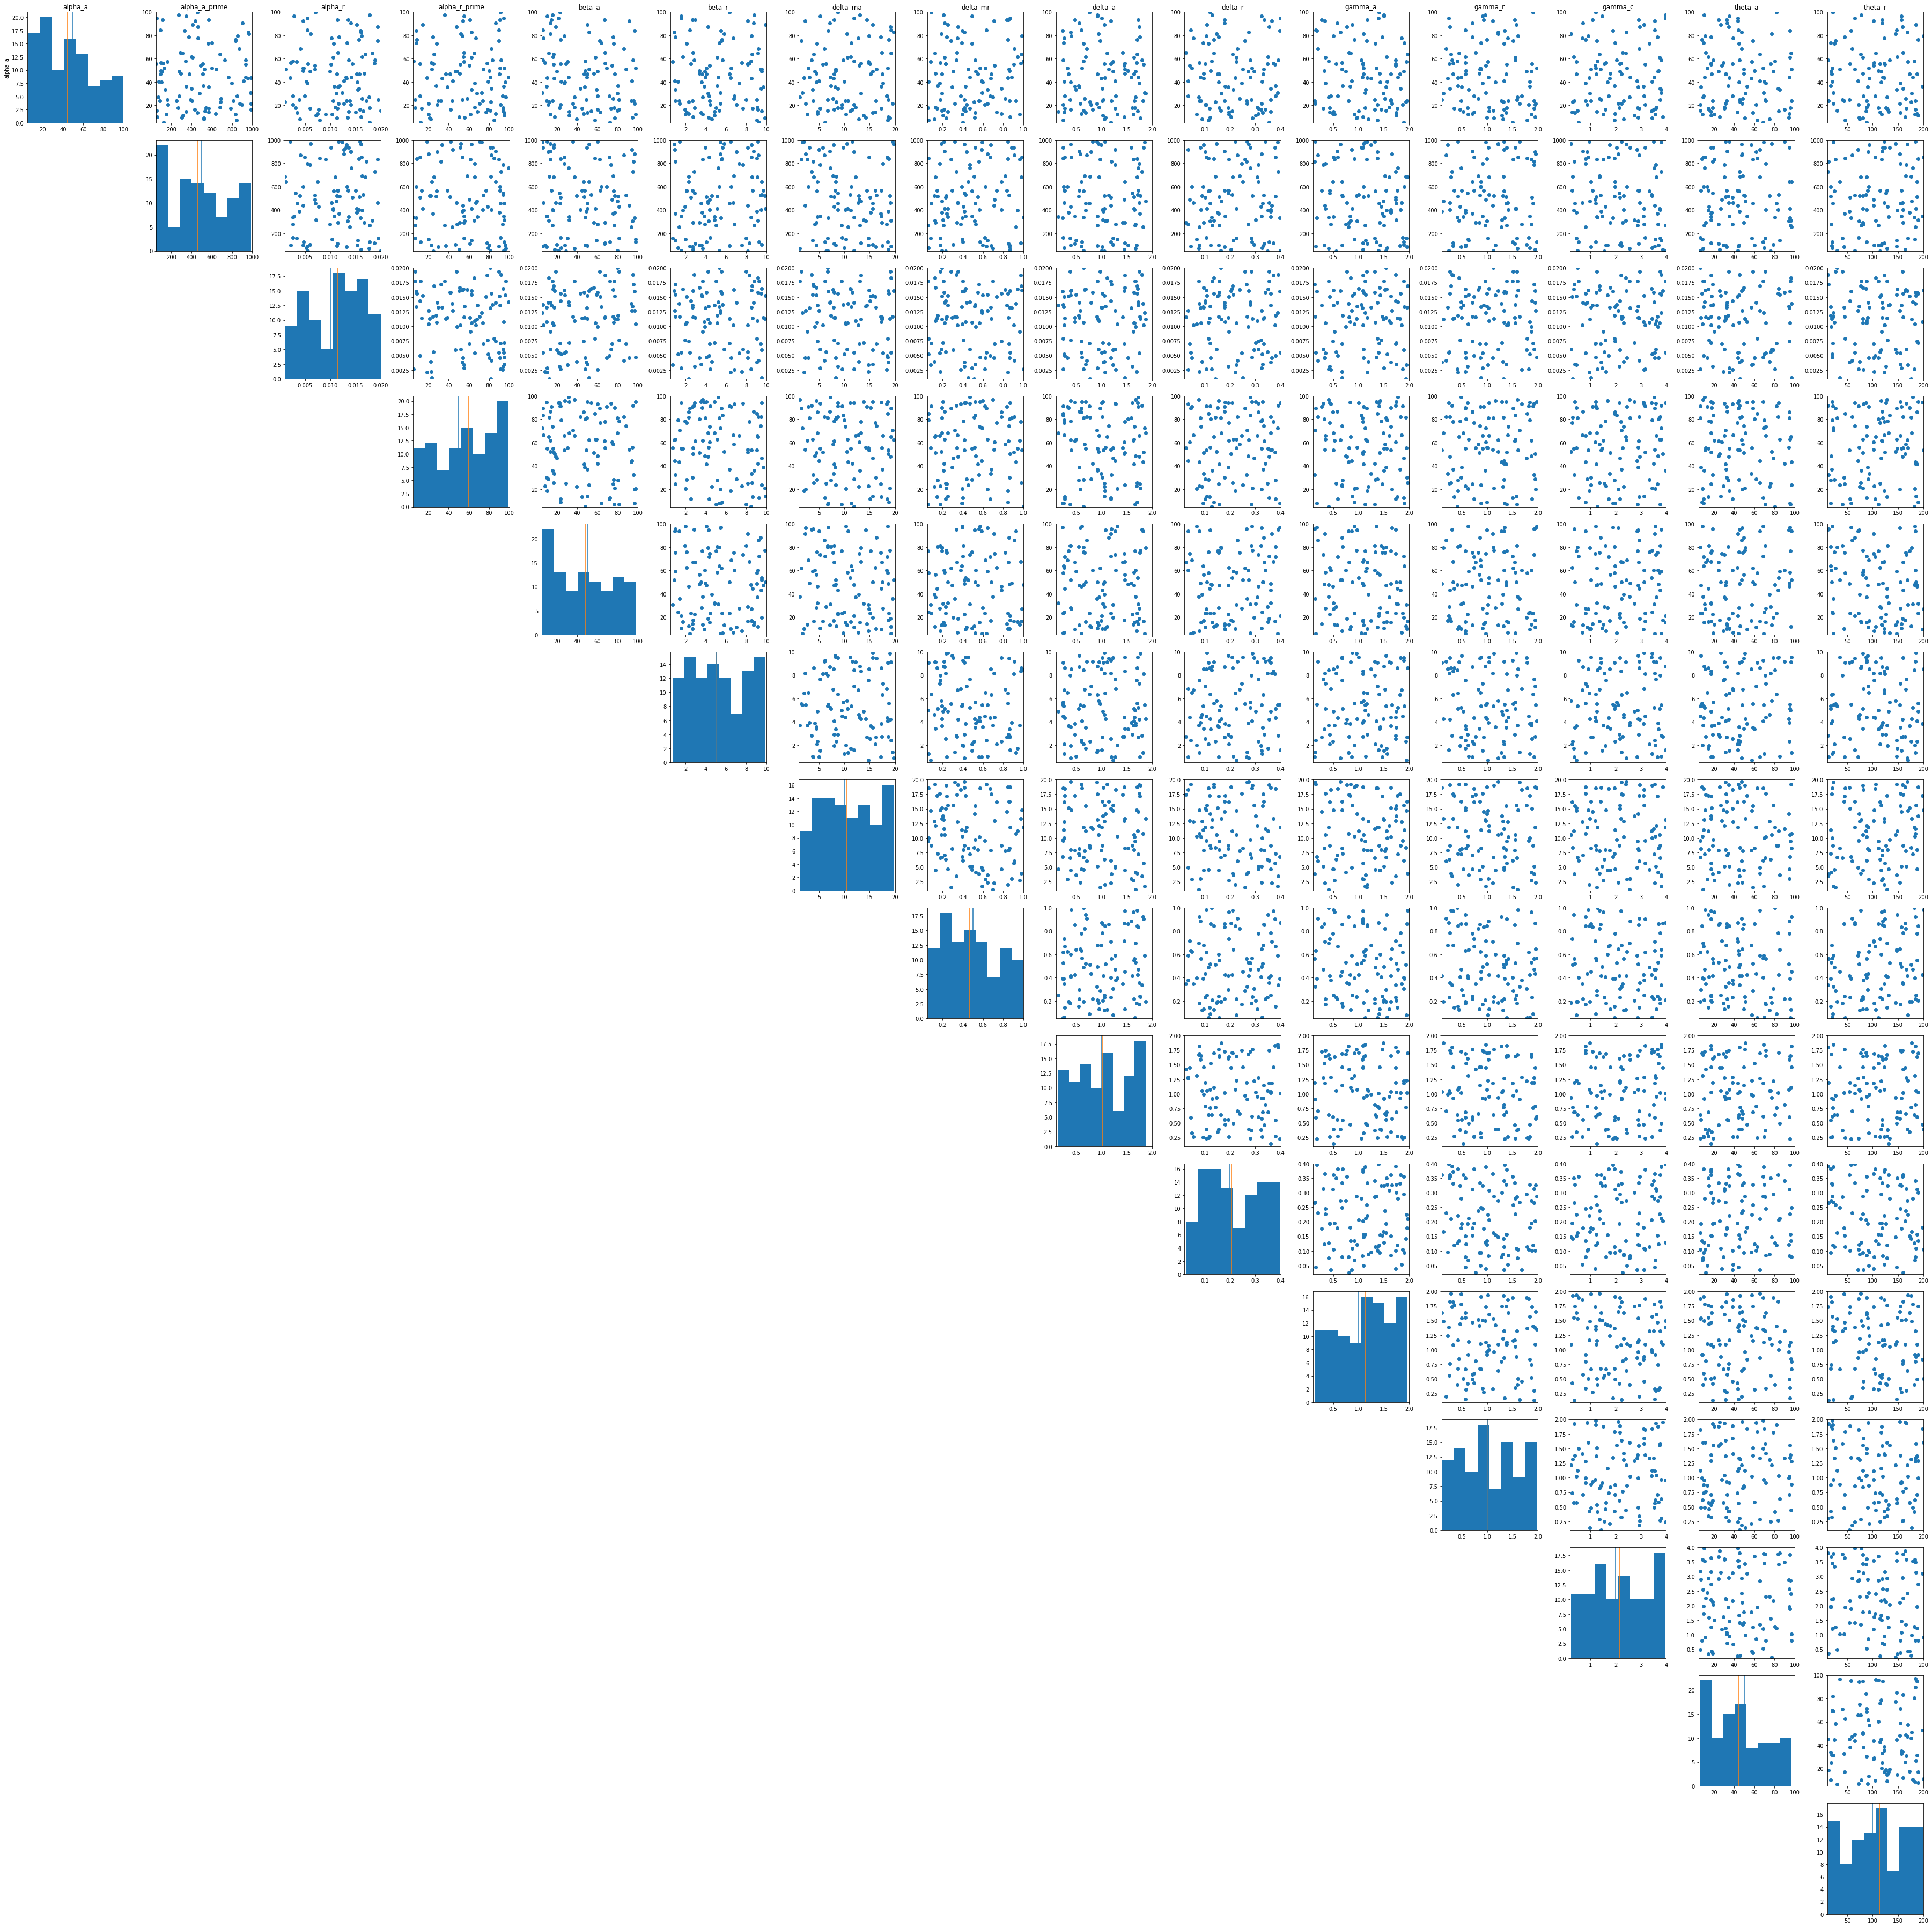

In [ ]:
fig, ax = plt.subplots(posterior1.shape[1], posterior1.shape[1], facecolor = 'w')
for i in range(posterior1.shape[1]):
    for j in range(posterior1.shape[1]):
        if i > j:
            ax[i,j].axis('off')
        else:
            if i == j:
                ax[i,j].hist(posterior1[:,i], bins = 'auto')
                ax[i,j].axvline(np.median(posterior1[:,i]), color = 'C1')
                ax[i,j].axvline(true_params[i])
                ax[i,j].set_xlim(lower_bounds[i], upper_bounds[i])
            else:
                ax[i,j].scatter(posterior1[:,j], posterior1[:,i])
                ax[i,j].set_ylim(lower_bounds[i], upper_bounds[i])
                ax[i,j].set_xlim(lower_bounds[j], upper_bounds[j])
    ax[i,0].set_ylabel(parameter_names[i])
    ax[0,i].set_title(parameter_names[i])
fig.set_size_inches(50,50)
fig.tight_layout()